# 3D Toric Code Sweep Decoder

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pymatching import Matching
import os
from panqec.bpauli import get_effective_error

from panqec.analysis import get_results_df_from_batch, get_thresholds_df
from panqec.plots._threshold import detailed_plot
from panqec.config import ERROR_MODELS

from panqec.simulation import (
    read_input_dict
)
from panqec.io import (
    serialize_results, dump_results
)
from tqdm.notebook import tqdm
from panqec.plots import plot_export_json
import IPython.display
import datetime
from panqec.config import PANQEC_DIR, PANQEC_DARK_THEME
if PANQEC_DARK_THEME:
    plt.style.use('dark_background')

import pandas as pd

In [42]:
# Parameters
# Change these as you wish.

input_data = {
    'comments': 'Simple Demonstration',
    'ranges': {
        'label': 'simple-demo',
        'code': {
            'model': 'Toric3DCode',
            'parameters': [
                {'L_x': 2},
                {'L_x': 3},
                {'L_x': 4},
#                 {'L_x': 3, 'L_y': 4, 'L_z': 4},
#                 {'L_x': 4, 'L_y': 5, 'L_z': 5},
#                 {'L_x': 5, 'L_y': 6, 'L_z': 6},
            ]
        },
        'noise': {
            'model': 'DeformedXZZXErrorModel',
            'parameters': [
                {'r_x': 1, 'r_y': 0, 'r_z': 0}
            ],
        },
        'decoder': {
            'model': 'BeliefPropagationOSDDecoder',
            'parameters': [{'joschka': True}]
        },
#         'probability': [0.02],
        'probability': np.arange(0.01, 0.4, 0.01).round(5).tolist(),
    }
}

# Frequecy of plot update.
plot_frequency = 5

# Frequency of saving to file.
save_frequency = 20

# Target number of simulations.
n_trials = 200

In [43]:
batch_sim = read_input_dict(
    input_data,
    update_frequency=plot_frequency,
    save_frequency=save_frequency
)

In [44]:
def update_plot():
    """Plot routine on loop."""
    remaining_time = batch_sim.estimate_remaining_time(n_trials)
    df = pd.DataFrame(batch_sim.get_results())

    plt.clf()
    for code_size in df['size'].unique():
        df_filtered = df[df['size'] == code_size]
        plt.errorbar(
            df_filtered['probability'], df_filtered['p_est'],
            yerr=df_filtered['p_se'],
            label=f'L={code_size[0]}'
        )
    plt.title(f'Time remaining {datetime.timedelta(seconds=int(remaining_time))}')
    plt.xlabel('Physical Error Rate', fontsize=20)
    plt.ylabel('Logical Error Rate', fontsize=20)
    plt.legend()
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())

batch_sim.on_update = update_plot

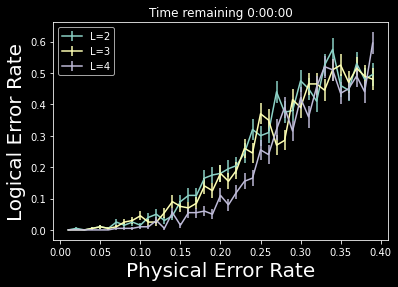

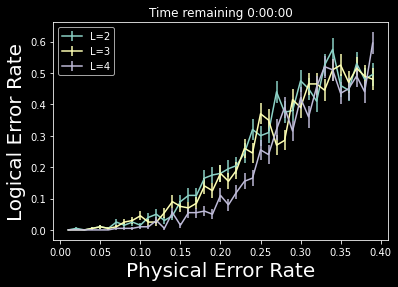

In [45]:
batch_sim._run(n_trials, progress=tqdm)

In [69]:
results_df = get_results_df_from_batch(batch_sim, input_data['ranges']['label'])
# error_model = 'Deformed XZZX Pauli X0Y0Z1'
# # xlim = (input_data['ranges']['probability'][0], input_data['ranges']['probability'][-1])
# xlim=[0.2, 0.5]
# print(xlim)
# detailed_plot(plt, results_df, error_model, x_limits=[xlim, xlim, xlim])

In [70]:
results_df

,size,code,n_k_d,error_model,probability,n_success,n_fail,n_trials,p_est,p_se,label,noise_direction,p_x,p_x_se,p_z,p_z_se
0,"(3, 3, 3)",Toric 3x3x3,"(81, 3, 3)",Pauli X1Y0Z0,0.02,9436,564,10000,0.0564,0.002307,toric-06,"(1, 0, 0)",0.0564,0.002307,0.0,0.0
1,"(5, 5, 5)",Toric 5x5x5,"(375, 3, 5)",Pauli X1Y0Z0,0.02,9730,270,10000,0.0270,0.001621,toric-06,"(1, 0, 0)",0.0270,0.001621,0.0,0.0
2,"(7, 7, 7)",Toric 7x7x7,"(1029, 3, 7)",Pauli X1Y0Z0,0.02,9827,173,10000,0.0173,0.001304,toric-06,"(1, 0, 0)",0.0173,0.001304,0.0,0.0
3,"(9, 9, 9)",Toric 9x9x9,"(2187, 3, 9)",Pauli X1Y0Z0,0.02,9891,109,10000,0.0109,0.001038,toric-06,"(1, 0, 0)",0.0109,0.001038,0.0,0.0


# Subthreshold scaling

In [76]:
from scipy.optimize import curve_fit
from scipy import optimize

In [77]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):
    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)

    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 2. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

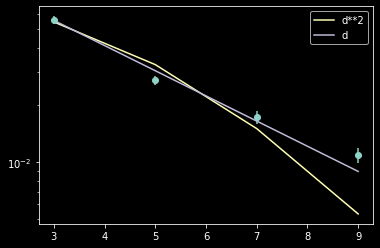

In [105]:
distances = [results_df['d'][i] for i in range(len(results_df))]
logical_p = results_df['p_est']
logical_p_std = results_df['p_se']

plt.errorbar(distances, logical_p, logical_p_std, fmt='o')
plt.plot(distances, np.vectorize(f_1)(distances, A_pred_1, B_pred_1), label="d**2")
plt.plot(distances, np.vectorize(f_2)(distances, A_pred_2, B_pred_2), label="d")
plt.legend()
plt.yscale('log')

In [101]:
def f_1(d, A, B):
    return A * np.exp(-B * d**2)

def f_2(d, A, B):
    return A * np.exp(-B * d)

In [102]:
# A_pred_1, B_pred_1 = curve_fit(f_1, distances, logical_p, method='lm')[0]
# A_pred_2, B_pred_2 = curve_fit(f_2, distances, logical_p, method='lm')[0]

In [103]:
def ff_1(x, p):
    return np.vectorize(f_1)(x,*p)

def ff_2(x, p):
    return np.vectorize(f_2)(x,*p)

In [104]:
pfit, perr = fit_bootstrap(np.array([1, 1]), distances, logical_p, ff_1)
A_pred_1, B_pred_1 = pfit

pfit, perr = fit_bootstrap(np.array([1, 1]), distances, logical_p, ff_2)
A_pred_2, B_pred_2 = pfit

/tmp/ipykernel_23647/1613346981.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * d**2)
